# Project CodeNet Program Classification with a TBCNN

This notebook shows an application of a TBCNN for classifying programs by functionality. In this experiment we use Python source code from Project CodeNet and predict their problem_id.

Structure of this notebook:
1. Creation of a derived dataset from Project CodeNet
2. Training of a TBCNN on this dataset
3. Visualizations of the Convolutional Layer of the Model using GraphViz
4. Analysis of some interesting findings

In [1]:
%load_ext autoreload
%autoreload 2

## Derived Dataset
The derived dataset contains only source code from submissions with status 'Accepted' and programs written in Python 3.4.3. This constraint allows us to parse the code with the built-in Python-module 'ast'.

First, we create an in-memory representation of the CodeNet dataset to retrieve the metadata of all submissions.

In [2]:
from dataset.CodeNet import CodeNet
code_net = CodeNet(location=r"C:\Users\sebas\Documents\Masterarbeit\Project_CodeNet")

In [3]:
submission_metadata = code_net.get_submission_metadata()
submission_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13916868 entries, 0 to 1088
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   submission_id      string
 1   problem_id         string
 2   user_id            string
 3   date               Int64 
 4   language           string
 5   original_language  string
 6   filename_ext       string
 7   status             string
 8   cpu_time           Int64 
 9   memory             Int64 
 10  code_size          Int64 
 11  accuracy           string
dtypes: Int64(4), string(8)
memory usage: 1.4 GB


pandas Dataframes allow us to query and recombine dataframes to construct the derived dataset.

In [4]:
accepted_python3_submissions = submission_metadata.query("original_language == 'Python (3.4.3)' and status == 'Accepted'")

We further use only submissions with more than 2500 submissions, so we have enough data to train on.

In [5]:
python3_submissions_count = accepted_python3_submissions.groupby(["problem_id", "status"]).size().reset_index(name="count").sort_values("count", ascending=False).query("count > 2500")

By merging these two dataframes we get the final derived data we want.

In [6]:
derived_dataset = accepted_python3_submissions.merge(python3_submissions_count, on="problem_id").drop(columns=["status_y"]).rename(columns={"status_x": "status"})

Finally, we use an instance of `ProblemIdClassificationDataset` to manage the dataset on disk. This class offers functionality to create training-, validation- and test-directory with the specified number of samples for each problem. All samples are randomly sampled from the `derived_dataset`

In [7]:
from dataset.ProblemIdClassificationDataset import ProblemIdClassificationDataset

classification_dataset = ProblemIdClassificationDataset(r"C:\Users\sebas\Documents\Masterarbeit\datasets\tbcnn_py3_2500",
                                                 derived_dataset,
                                                 code_net,
                                                 n_train_per_problem=600,
                                                 n_val_per_problem=100,
                                                 n_test_per_problem=300)

The `create_or_load`-method creates an in-memory representation of the classification-dataset or loads it if it already exists in the file system. More specifically, following steps happen during creation:
1. For each `problem_id` in the `derived_dataset` 1000 submissions are sampled (see parameter of Ctor in previous cell).
2. The 1000 samples are split up into train-, validation- and test-partitions according to the parameter in the previous cell. These partitions are represented by dataframes which are serialized with `pickle` for later loading.
3. Each source file is parsed with the `ast` module and a simpler tree in JSON format is created and placed in its respective directory (train, val or test)
4. All encountered AST node types are collected in a map (str->int) and serialized (node_map).
5. All encountered problem_ids (classification labels) are collected and serialized

In [8]:
classification_dataset.create_or_load()

## TBCNN

### Model Creation

In [99]:
from keras.metrics import Precision, Recall
import tensorflow as tf
from classifier.Tbcnn import Tbcnn
node_map = classification_dataset.get_node_map()
labels = classification_dataset.get_labels()
model = Tbcnn(feature_size=len(node_map), conv_output_size=100, num_classes=len(labels))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam',
              metrics = [tf.keras.metrics.CategoricalAccuracy(), Precision(), Recall()])

### Model Training

In [100]:
from generators.FileStreamDataGenerator import FileStreamDataGenerator

train_files = classification_dataset.get_train_files()
val_files = classification_dataset.get_val_files()
training_generator = FileStreamDataGenerator(train_files, labels, node_map, batch_size=1, shuffle=True)
validation_generator = FileStreamDataGenerator(val_files, labels, node_map, batch_size=1, shuffle=False)
model.fit(training_generator, validation_data=validation_generator, epochs=1)

75600/75600 [==============================] - 187s 2ms/step - loss: 0.6202 - categorical_accuracy: 0.8519 - precision_4: 0.9473 - recall_4: 0.7794 - val_loss: 0.2783 - val_categorical_accuracy: 0.9214 - val_precision_4: 0.9495 - val_recall_4: 0.9012


### Model Evaluation

Next, we evaluate the model on our testset and collect the predicted lables (y_hat).

In [101]:
test_files = classification_dataset.get_test_files()
test_generator = FileStreamDataGenerator(test_files, labels, node_map, batch_size=1, shuffle=False)
y_hat = model.predict(test_generator)
metrics = model.evaluate(test_generator)

37800/37800 [==============================] - 63s 2ms/step - loss: 0.2774 - categorical_accuracy: 0.9215 - precision_4: 0.9494 - recall_4: 0.9021


In [102]:
from numpy import argmax
labels = list(test_generator.get_label_lookup().keys())
expected_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    expected_label = labels[argmax(y)]
    predicted_label = labels[argmax(y_hat[i])]
    expected_labels.append(expected_label)
    predicted_labels.append(predicted_label)

A confusion matrix allows us to visualize and analyse the output of the model. As the matrix is big (126 x 126) it is best to open it in a separate window.

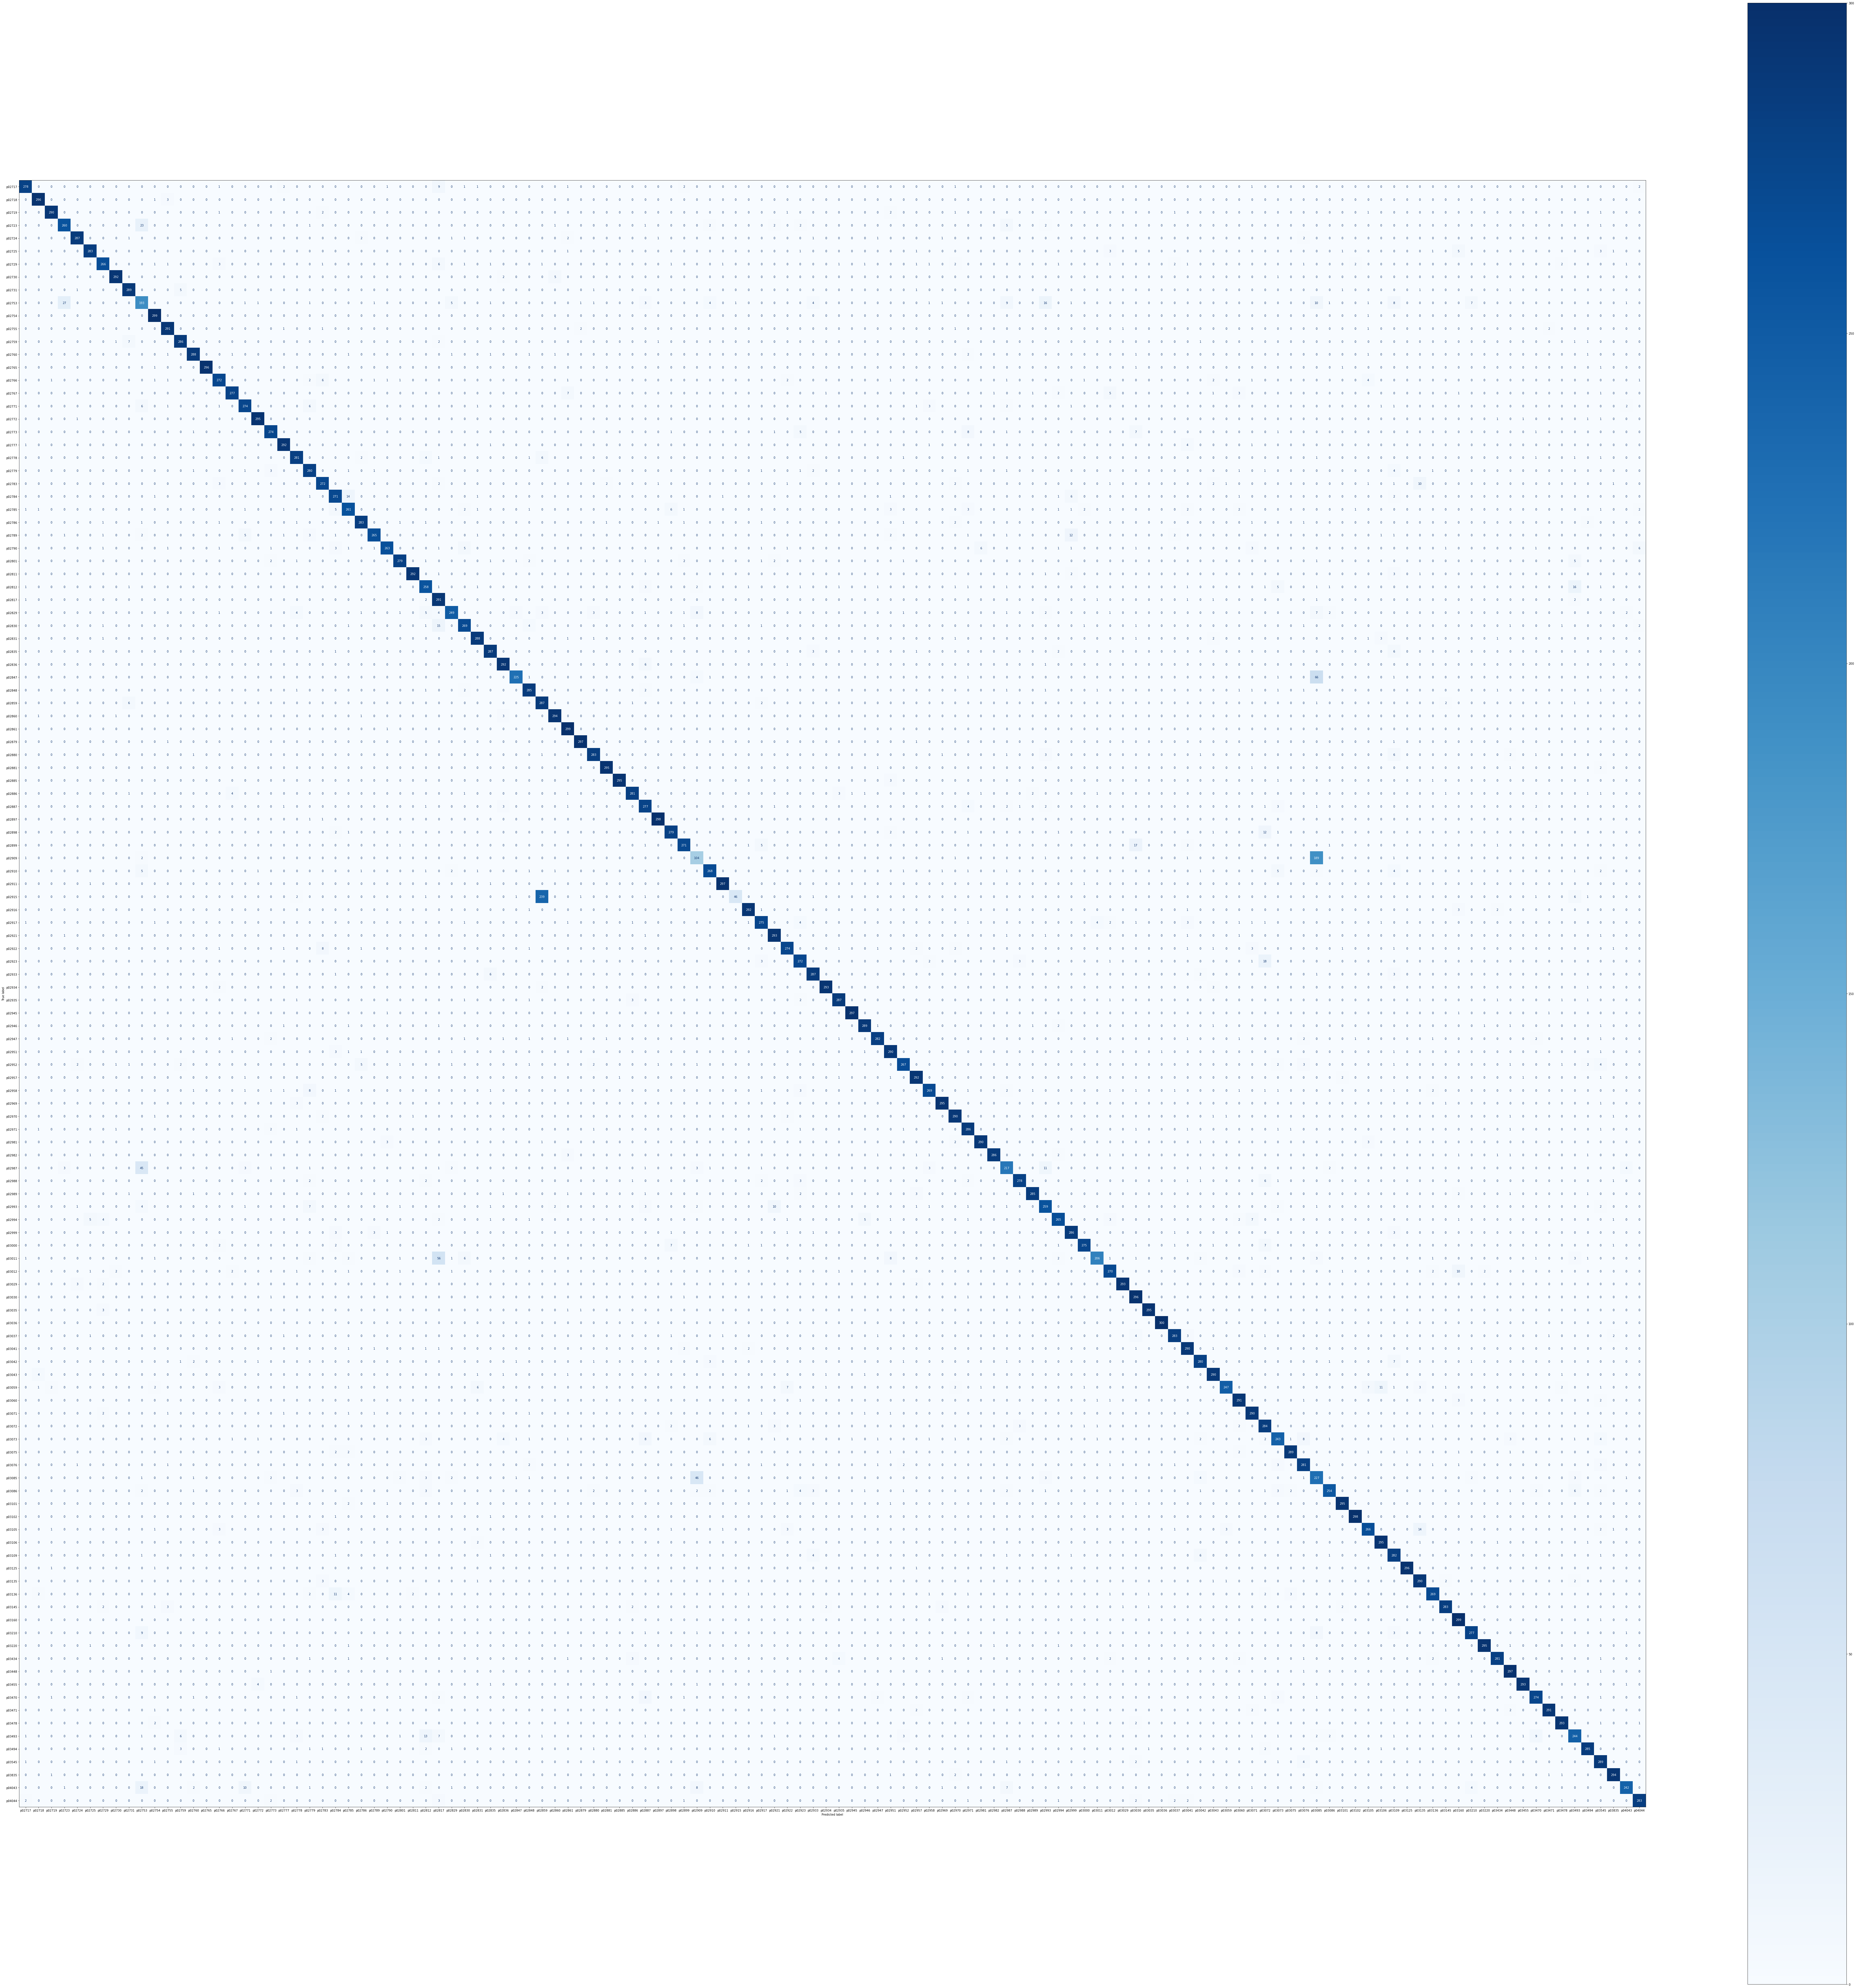

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(126, 126))
cm = confusion_matrix(expected_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

We can see that, most problems are predicted correctly. Please find a more in-depth analysis in the last section of this notebook.

Additionaly, we create a classification report with common metrics like precision, recall and f1-score.

In [104]:
from sklearn.metrics import classification_report

print(classification_report(expected_labels, predicted_labels, labels=labels))

              precision    recall  f1-score   support

      p02717       0.96      0.93      0.94       300
      p02718       0.97      0.99      0.98       300
      p02719       0.98      0.97      0.97       300
      p02723       0.89      0.87      0.88       300
      p02724       0.97      0.96      0.96       300
      p02725       0.97      0.94      0.95       300
      p02729       0.94      0.89      0.91       300
      p02730       0.98      0.97      0.98       300
      p02731       0.94      0.96      0.95       300
      p02753       0.62      0.64      0.63       300
      p02754       0.95      1.00      0.97       300
      p02755       0.95      0.97      0.96       300
      p02759       0.94      0.95      0.95       300
      p02760       0.96      0.96      0.96       300
      p02765       1.00      0.99      0.99       300
      p02766       0.92      0.91      0.91       300
      p02767       0.97      0.92      0.95       300
      p02771       0.92    

## Visualization

Finally, we can visualize the output of the convolutional- and max pooling layer. The output of the convolutional layer is essentially a list of 100 dimensional vectors (one vector for each node in the AST). This list serves as the input to the max pooling layer, which creates a single 100 dimensional vector where each vector component is the maximum of all components with the respective component index in the list of vectors. By tracking from which node the components are taken we can calculate a measure for how important a single node is. I.e. if many components are taken from a specific node, we conclude that this node is important for the prediction. We then use this measure to calculate the saturation of the color of the node: a high saturation denotes a great importance of a node and vice versa.

The following simple example shows, how the importance of a node is calculated. The value of conv_out represents an AST with 3 nodes as a tensor with the shape BATCH_SIZE x TREE_SIZE x CONV_OUT_SIZE. This is the output of the `ContinuousBinaryTreeConvLayer`.

In [69]:
conv_out = [[[1,2,5], [3,2,2], [1,1,4]]]

The `DynamicMaxPoolingLayer` uses the `reduce_max` operation to ensure a fixed size representation of the entire AST. We can see that, for each component with index `i` it extracts the maximum component with index `i` of all node vectors.

In [70]:
tf.reduce_max(conv_out, axis=1)

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 2, 5]])>

With the `argmax` operation we get the index of the node from which the respective component was extracted. In our example the second node has the maximum value of component 0 of all nodes, the first node has the maximum value of component 1 and 2. Using this measure, we conclude that the first node with index 0 is most important, followed by the node with index 1. As the last node does not appear in the this vector, it is not considered by the classification layer and therefore has zero importance.

In [71]:
tf.argmax(conv_out, axis=1),

(<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[1, 0, 0]], dtype=int64)>,)

### Visualizations of submissions for problem_id 'p02717'

Following cell contains the original problem description for this problem_id from the CodeNet data set:

In [153]:
from IPython.display import HTML
HTML(filename=r"C:\Users\sebas\Documents\Masterarbeit\Project_CodeNet\problem_descriptions\p02717.html")

#### Visualization #1

In [111]:
from collections import Counter
from visualization.GraphvizVisualizer import GraphvizVisualizer

Following example visualizes the model output for the first sample of the testset.

In [119]:
sample_id = 0

The source code of this sample:

In [120]:
test_file_submission_id = classification_dataset.get_test_df().iloc[[sample_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[sample_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id.to_string(index=False)}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
X,Y,Z=input().split()
print(Z,X,Y)


Result of the prediction:

In [128]:
predicted_labels[sample_id]

'p02717'

The prediction is correct.

The visualization of the AST:

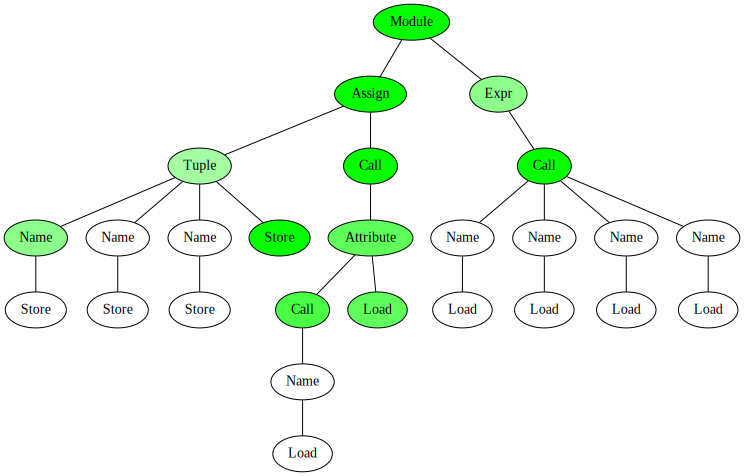

In [110]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(sample_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

Findings and Interpretation:
- Many nodes have a high importance, probably because it is a short program, and we have 100 components in the output vector of the pooling layer.
- The 'Tuple' and 'Assign' nodes have a high importance, which does make sense as they are crucial for Python programs.
- The 'Call' nodes have high importance (note that the network only "sees" the node type, and not the actual value of the symbol (i.e. 'input'). But as the vector for a node is a combination of its children there should be some structural information). This indicates that 'Call' nodes offer useful information. This does make intuitively sense.
- The 'Tuple' node has 3 identical children, but only the first one is considered. This is because the `argmax` operation of the max pooling layer returns the first index the maximum value is encountered, so following components of nodes with the same value are ignored.
- Nodes representing identifiers ('Name') do get low importance. Perhaps because they are very common.
- Why does the 'Load' node get such a high importance? This node represents the context of the AST node and is one of 'Load', 'Store' or 'Del'. So it also should get low importance because it should be very common. Maybe this is because this sample has such a low number of nodes, so the final vector ("forcefully") contains components of otherwise useless nodes.
- The 'Load' node gets a higher importance than the 'Store' node.

#### Visualization #2

For our second visualization we look at a different submission for the same problem_id.

In [154]:
sample_id = 1
test_file_submission_id = classification_dataset.get_test_df().iloc[[sample_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[sample_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id.to_string(index=False)}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
x, y, z = map(int,input().split())

a = x
b = y
c = z

z = str(b)
y = str(a)
x = str(c)

print(x +" " + y + " " + z) 


In [137]:
predicted_labels[sample_id]

'p02717'

The prediction is correct.

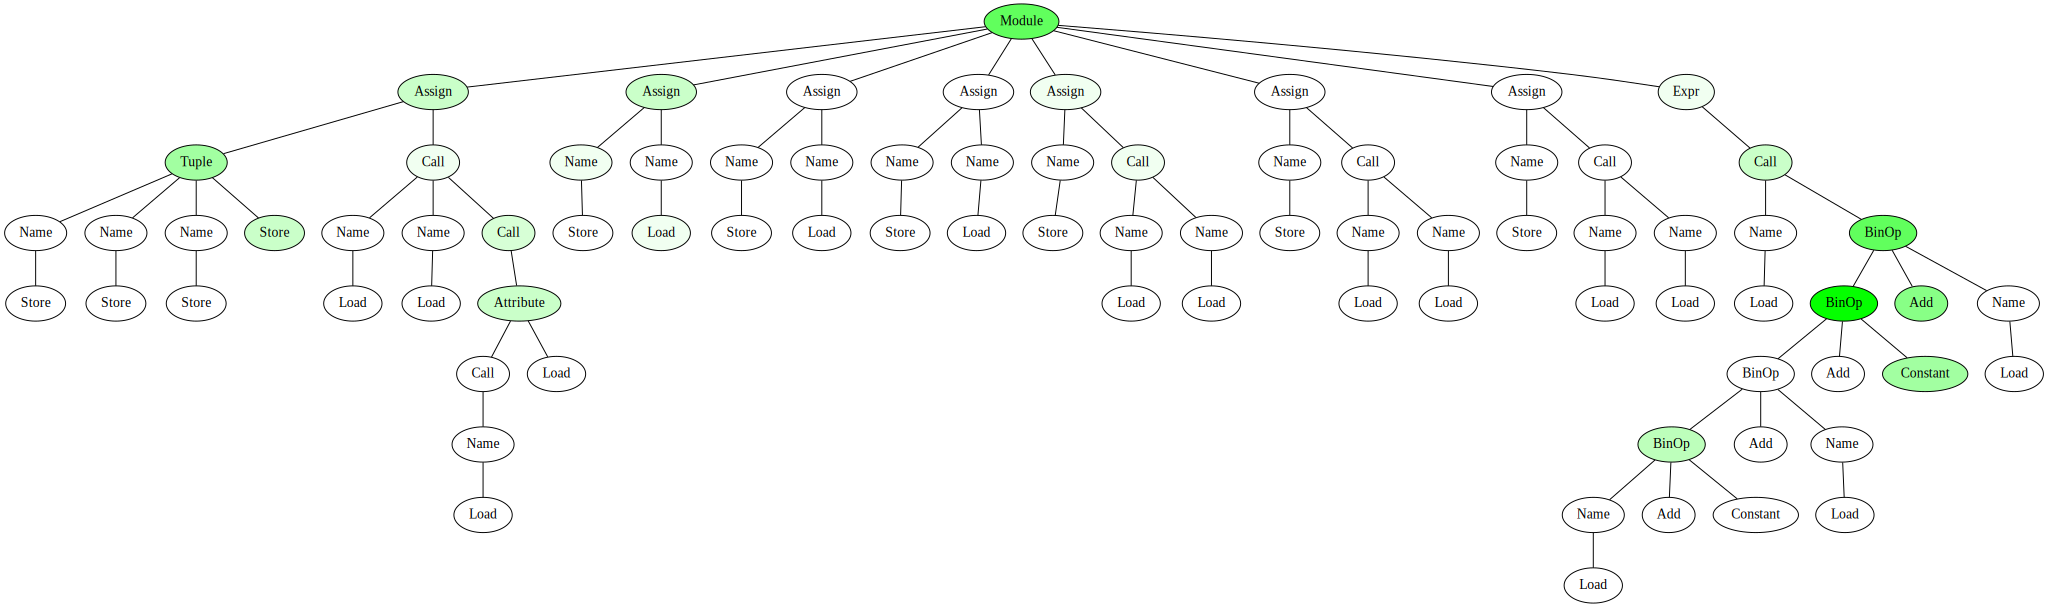

In [155]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(sample_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

Findings and interpretation:
- Again, the module node has a high importance. Probably because it contains a lot of information. This is because the parents are a combination of its children (Tree-based convolution).
- Again the 'Tuple', 'Assign' and 'Call' nodes get high importance, although less than in the previous sample. This is probably because of the higher number of nodes in the AST. This further indicates a ranking of nodes.
- Interestingly, the 'Call' node for `split()` has low priority in this sample. The 'Call' node for `input()` has medium priority. This is different to the first visualization. Also, the 'Load' node of 'Attribute' has no priority in this sample.
- The 'BinOp' nodes in the `print()` call have a high priority. This may indicate that they contain a lot of information for the network and are generally more important for the task of program classification.
- The 'Load' node of the second 'Assign' node gets some importance, but a loot less than previously. As this AST contains a lot more nodes the max pooling layer "chooses" from, this supports our previous argument that it only got high importance because the AST contained few nodes.

#### Visualization #3

In [170]:
sample_id = 2
test_file_submission_id = classification_dataset.get_test_df().iloc[[sample_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[sample_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id.to_string(index=False)}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
x,y,z=(int(a) for a in input().split());
print(z,x,y);

  


In [171]:
predicted_labels[sample_id]

'p02717'

The prediction is correct.

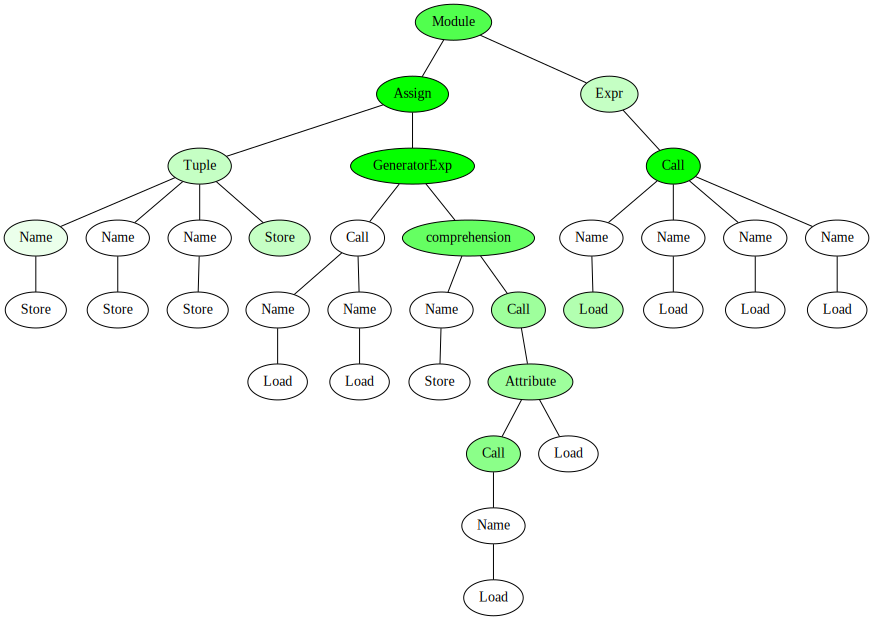

In [172]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(sample_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

Interpretation:
- Again, the module node has high importance.
- Also, the 'Tuple' and the assignment to it get a high importance.
- Also, the 'Call' node for `input()` and the respective 'Attribute' node get a high importance again. Interestingly also the 'Call' node for `split()` gets a high importance again. This is similar to the first visualization.
- Also, the 'Call' node for `print()` gets an importance similar to the first visualization again.
- An interesting aspect of this sample is the usage of a 'GeneratorExpr' which also gets a high priority. This indicates that 'GeneratorExpr' nodes contain a lot of important information and therefore are important for the task of program classification.

#### Visualization #4

In [173]:
sample_id = 3
test_file_submission_id = classification_dataset.get_test_df().iloc[[sample_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[sample_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id.to_string(index=False)}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
x,y,z = map(int,input().split())
x,y = y,x
x,z = z,x
print(x,y,z)


In [174]:
predicted_labels[sample_id]

'p02717'

The prediction is correct.

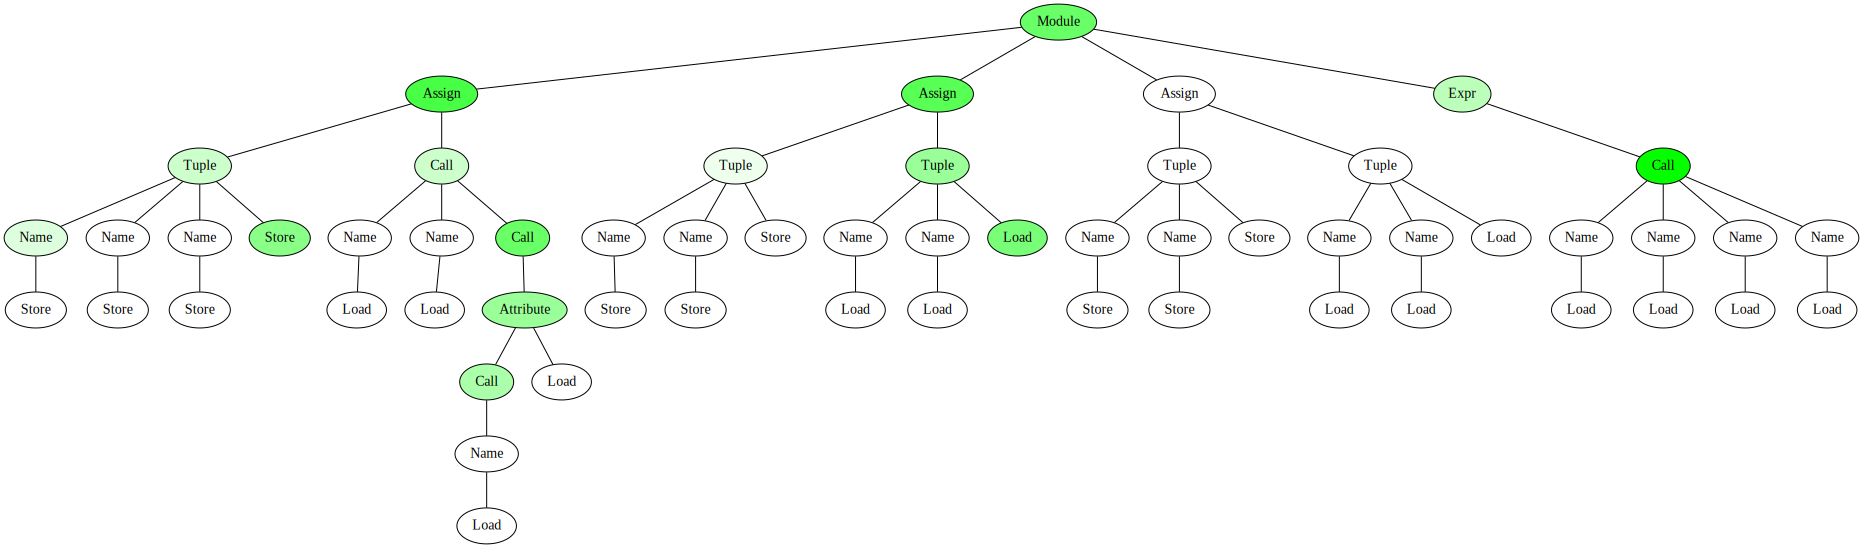

In [175]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(sample_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

Interpretation:
- Like we saw before: 'Module', 'Tuple', 'Assign', and 'Call' nodes get high importance. This indicates that they are important for the task of program classification.

#### Visualization #5

Now we look at some misclassified samples. The first 300 samples of the test set are for problem_id 'p02717'

In [177]:
misclassified_sample_ids = []
for i in range(300):
    if predicted_labels[i] != expected_labels[i]:
        misclassified_sample_ids.append((i, predicted_labels[i]))
print(misclassified_sample_ids)

[(28, 'p04044'), (77, 'p04044'), (86, 'p02831'), (107, 'p02899'), (146, 'p02899'), (178, 'p02817'), (195, 'p02861'), (204, 'p02817'), (226, 'p02790'), (233, 'p02817'), (241, 'p02817'), (247, 'p03071'), (256, 'p02766'), (260, 'p02817'), (269, 'p02777'), (275, 'p02970'), (278, 'p02817'), (282, 'p02777'), (287, 'p02817'), (288, 'p02817'), (292, 'p02817'), (299, 'p02830')]


In [178]:
sample_id = 28
test_file_submission_id = classification_dataset.get_test_df().iloc[[sample_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[sample_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id.to_string(index=False)}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
a,b,c=[int(x) for x in input().split()]
a,b=b,a
a,c=c,a
print(a,b,c,end=" ")


In [182]:
predicted_labels[sample_id]

'p04044'

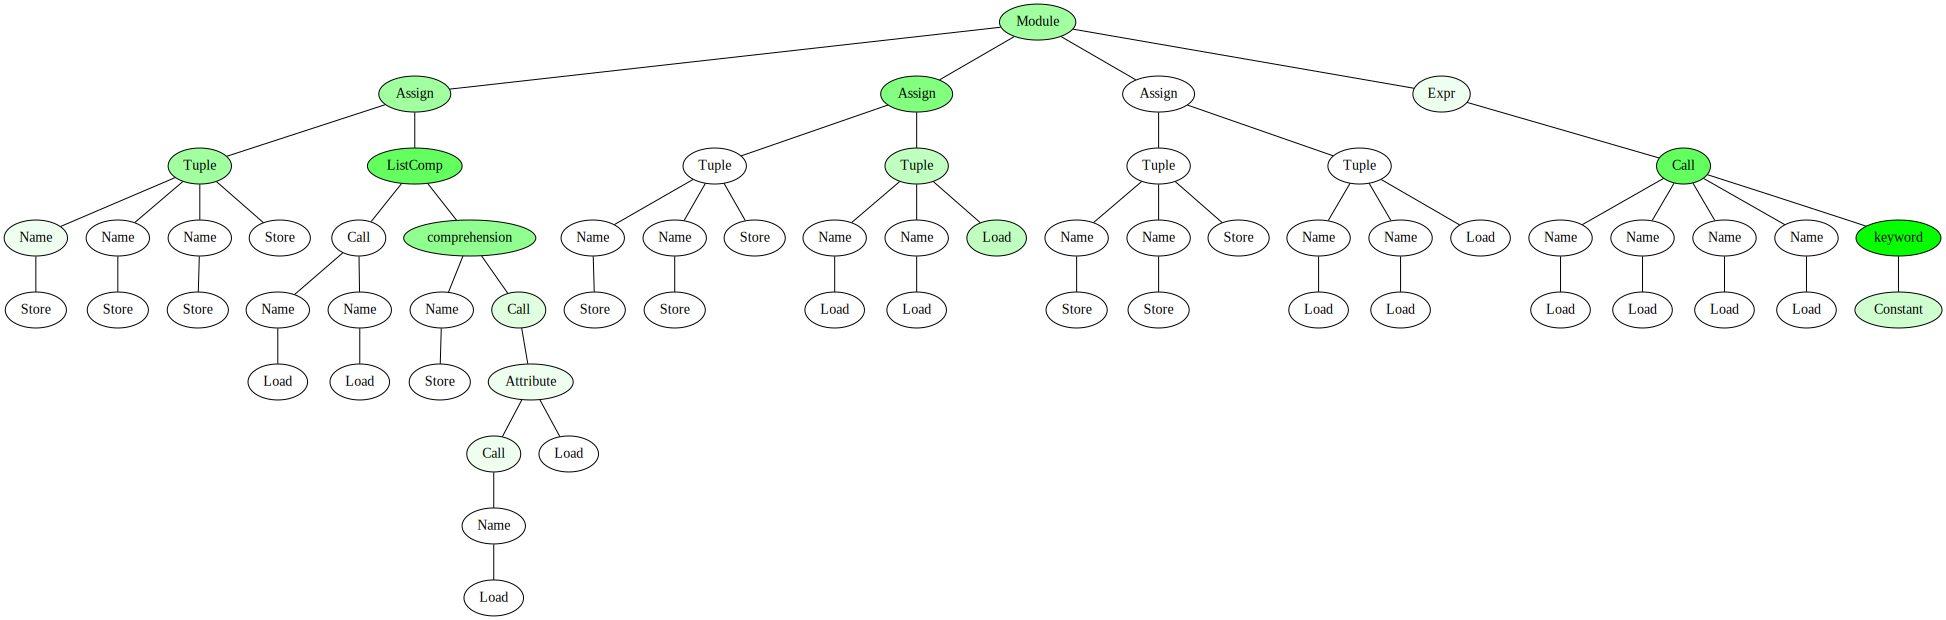

In [179]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(sample_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

Interpretation:
- For humans the code looks similar to the code in the first visualizations.
- An important difference for the network seems to be the 'ListComp' node.
- Also the 'Call' and 'Attribute' for the `input()` call get less importance than previously.
- This may indicate that in our training set only few examples with 'ListComp' nodes exists and therefore the network does not associate that node with this problem.
- The newly seen node 'keyword' gets a high importance which indicates that these are important for the task of program classification.
- It may be that 'ListComp' and 'keyword' nodes are characteristic for submissions for problem_id 'p04044' (the predicted label for this sample).

#### Visualization #6

Another sample misclassified as 'p04044'

In [180]:
sample_id = 77
test_file_submission_id = classification_dataset.get_test_df().iloc[[sample_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[sample_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id.to_string(index=False)}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
import math
import numpy as np

w=0
x,y,z=(int(x) for x in input().split())
w=x
x=z
z=y
y=w
print(x,y,z,sep=" ")



In [183]:
predicted_labels[sample_id]

'p04044'

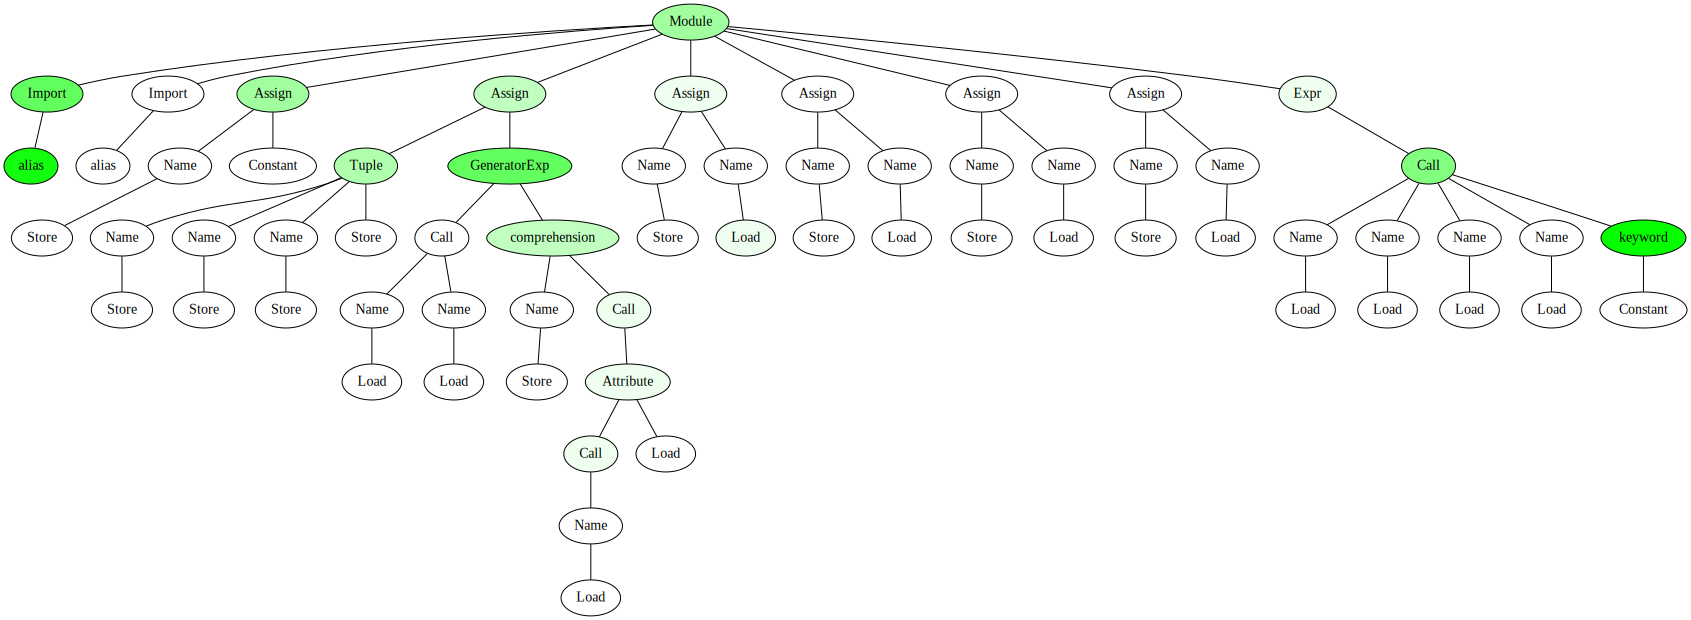

In [181]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(sample_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

Interpretation:
- This sample does not contain a 'ListComp' node, but still a 'keyword' node. This indicates that 'keyword' nodes are characteristic for 'p04044'
- Interestingly the 'Import' and 'alias' nodes get high importance, although they seem very common for Python programs (maybe not in our training set?).

#### Conclusion
- The importance of nodes for a concrete sample depends on the size of the AST (for small ASTs otherwise useless nodes get a high importance)
- The importance of nodes depends on its children (expected because the parent nodes are a combination of its children).
- Only the first of multiple identical nodes is considered by the max pooling layer (expected because of the `argmax` operation which returns only the first index of the node with the maximum value in the respective vector component).
- It is hard to interpret the result by analysing individual samples.
- The current (derived) data set may be too less diverse (e.g. the existance of the 'keyword' node seem to cause misclassifications).
- Only the node type is considered not the actual value of the terminal (this may be important for 'Call' nodes)

#### Possible Further Work
- Calculate a global importance ranking of nodes (imagine an AST containing all possible nodes, the resulting importance should be relative global importance of each node)
- Instead of predicting the problem_id, is it possible to cluster the programs (e.g. search, optimization, IO etc.)
- How does a more complex model behave (e.g. multiple convolutional layers, pre-trained embeddings)